In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import scipy.sparse as sp
#from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import seaborn
import random


# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Making Synthetic Data for testing

In [2]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = sp.random(4,52, density = 0.07).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [3]:
W,H = gen_data()
X = np.dot(W,H)

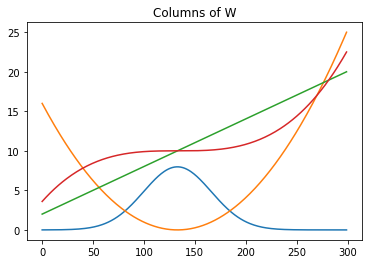

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

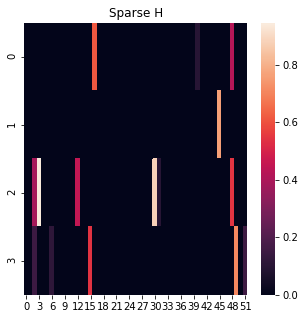

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.9001590419871148


In [7]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.21078519104020454


### Comparing SparseNMF with Sklearn NMF

In [1]:
def plotter(data, out_W,out_H, K_in = None, title = " "):
    # plot columns of W
    fix, ax = plt.subplots(1, 2, figsize = (10,5))
    for col in out_W:
        ax[0].plot(out_W.loc[:,col])
        ax[1].plot(W.loc[:,col])

    ax[0].set_title("W output for " + str(title))
    ax[1].set_title("Original columns of W")
    
    # plot heatmap of H
    fig, ax = plt.subplots(1, 2, figsize = (10,5))
    seaborn.heatmap(out_H, square = False, cbar = True, ax = ax[0])
    ax[0].set_title("H output for " + str(title))
    seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
    ax[1].set_title("Original H")
    
    plt.show()
    
    if K_in is None:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on X: ", np.linalg.norm(data - np.dot(out_W, out_H)))
    else:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on D: ", np.linalg.norm(data - np.dot(out_W, np.dot(out_H,K_in))))
    print()

### Sparse NMF

In [9]:
model = SparseNMF(X, 4, iterations = 1000, sH = h_sparse)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

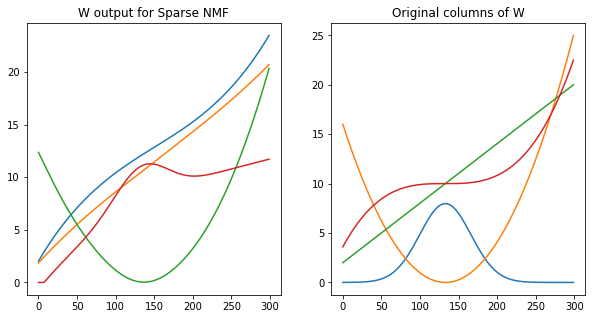

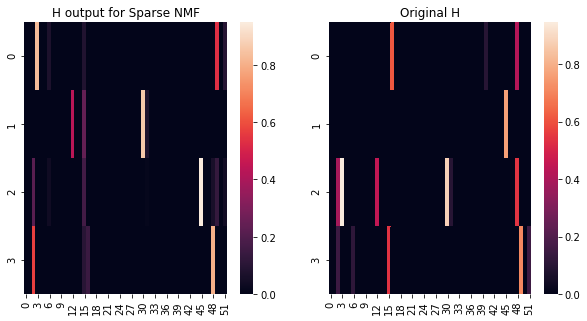

Sparse NMFerror on W:  296.03874686998626
Sparse NMFerror on H:  2.796323059322647
Sparse NMFerror on X:  40.661626986261616



In [10]:
plotter(X, spW, spH, title = "Sparse NMF")

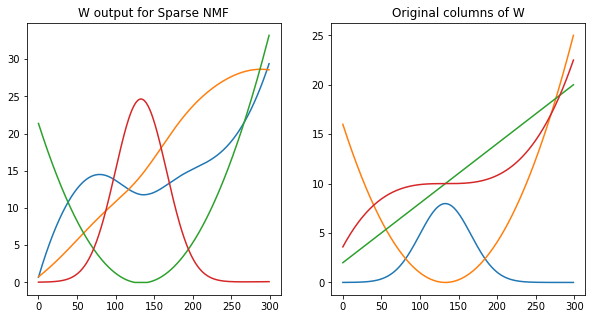

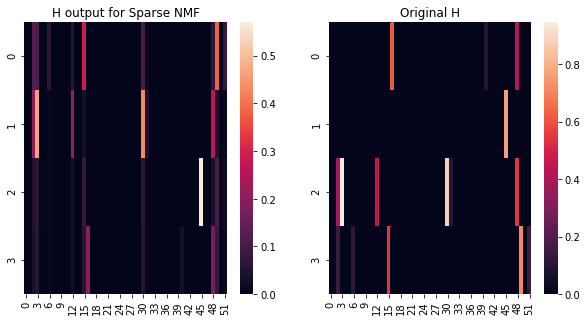

Sparse NMFerror on W:  411.5484964336489
Sparse NMFerror on H:  2.241204784760397
Sparse NMFerror on X:  0.4503676737838569



In [11]:
model = SparseNMF(X, 4, iterations = 1000, sH = h_sparse, tol = 1e-20)    
model.hoyer_solver(20)
#model.W = model.W * (W.max().max()/model.W.max())
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)
plotter(X, spW, spH, title = "Sparse NMF")

#### Sklearn

In [12]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

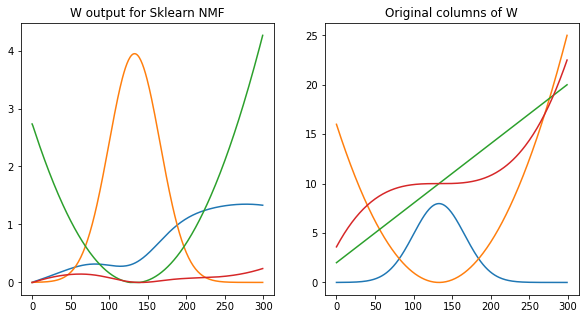

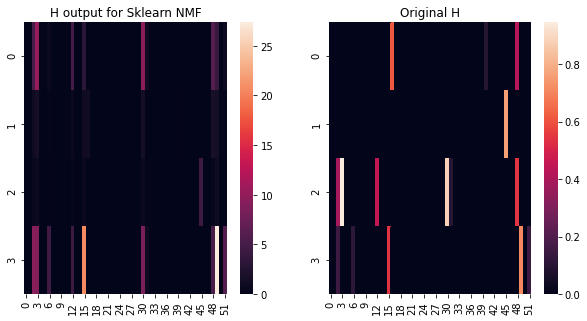

Sklearn NMFerror on W:  328.2676466105128
Sklearn NMFerror on H:  42.4418926746858
Sklearn NMFerror on X:  0.17502302429414296



In [13]:
plotter(X, sciW, sciH, title = "Sklearn NMF")

# Diffusion NMF

### Random Laplacian

In [14]:
# Making a synthetic laplacian and corresponding diffusion kernel:
def make_lapl(zero_prob, ones_prob):
    locs = X.shape[1]
    lapl = np.zeros((locs,locs))
    
    for i in range(lapl.shape[0]):
        for j in range(lapl.shape[1]):
            if i == j:
                break
            else:
                lapl[i,j] = -1 * np.random.choice([0,1], p = [zero_prob, ones_prob])
                lapl[j,i] = lapl[i,j]
    
    for i in range(lapl.shape[0]):
        lapl[i,i] = abs(lapl[i].sum())
        
    return lapl

In [15]:
I = np.identity(X.shape[1])

### Analyzing condition number of K

In [16]:
betav = 3
probs = np.flip(np.linspace(0,1,20))
connections = []
cond = []
for prob in probs:
    lapp = make_lapl(prob, 1 - prob)
    
    connections.append(np.trace(lapp))
    
    Kt = np.linalg.inv(I + betav * lapp)
    cond.append(np.linalg.cond(Kt))

Text(0, 0.5, 'Condition number')

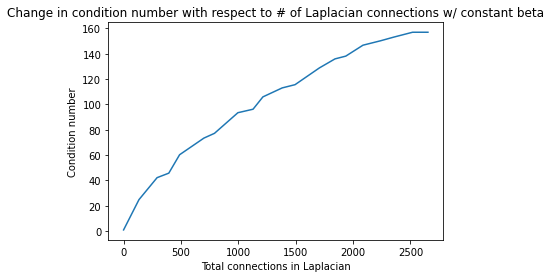

In [17]:
plt.plot(connections, cond)
plt.title("Change in condition number with respect to # of Laplacian connections w/ constant beta")
plt.xlabel("Total connections in Laplacian")
plt.ylabel("Condition number")

In [18]:
lapx = make_lapl(0.7, 0.3)
betas = np.linspace(1,30,30)
cond = []
for b in range(30):
    Kx = np.linalg.inv(I + b * lapx)
    cond.append(np.linalg.cond(Kx))

Text(0, 0.5, 'Condition number')

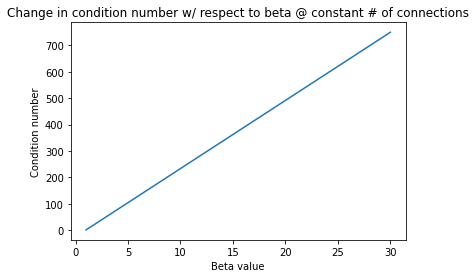

In [19]:
plt.plot(betas, cond)
plt.title("Change in condition number w/ respect to beta @ constant # of connections")
plt.xlabel("Beta value")
plt.ylabel("Condition number")

In [20]:
def reorder(x, y, axis = 1):
    # re orders the columns or rows of x and y so that they line up by highest correlation
    if axis == 0:
        # columns
        corr_mat = np.corrcoef(x.T, y.T)
        dim = len(x.T)
    else:
        # rows
        corr_mat = np.corrcoef(x, y)
        dim = len(x)
        
    perm = []
    for crow in range(len(corr_mat) // 2):
        maxc = -1
        indc = 0
        for coff in range(len(corr_mat[crow])//2, len(corr_mat[crow])):
            if corr_mat[crow][coff] > maxc and (coff - dim) not in perm:
                indc = coff - dim
                maxc = corr_mat[crow][coff]

        perm.append(indc)

    if axis == 0:
        return y[:,perm]
    else:
        return y[perm]

In [22]:
def correlation(x, y, axis = 1):
    # computes the correlation between matrices x and y
    summer = 0
    if axis == 0:
        for r in range(len(x.T)):
            corr = np.corrcoef(x.T[r], y.T[r])[0][1]
            if not np.isnan(corr):
                summer += corr
        cor_avg = summer / len(x.T)
        return cor_avg
    else:
        for r in range(len(x)):
            corr = np.corrcoef(x[r], y[r])[0][1]
            summer += corr
        cor_avg = summer / len(x)
        return cor_avg

In [25]:
def diffn_plot(w, h, lap, beta_vals, iters = 1000, algorithm = 'MultUpdate', sparseness = None, lambda_v = None, beta = None, eta = None):
    # plot the diffusion NMF results over a range of beta values
    # parameters include original w and h, the laplacian, desired level of sparseness, total iterations for NMf
    # and options for a projection version of the algorithm and an alternating least squares version
    
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, iterations = iters, tol = 1e-20)
            differ.solver(algorithm, sparseness, lambda_v, beta, eta)
                
            diffX = pd.DataFrame(reorder(W, differ.X, axis = 0))
            diffV = pd.DataFrame(reorder(H, differ.V, axis = 1))

            plotter(D, diffX, diffV, K_in = K, title = "Diffusion NMF @ beta = " + str(beta) + " ")
            
            print("Diffusion NMF X correlation with W: ", correlation(W.to_numpy(), diffX.to_numpy(), axis = 0))
            print("Diffusion NMF V correlation with H: ", correlation(H.to_numpy(), diffV.to_numpy(), axis = 1))
            print()

In [26]:
L = make_lapl(0.7, 0.3)

In [27]:
# total number of edges
np.trace(L)

848.0

K Condition Number : 27.477130643608547


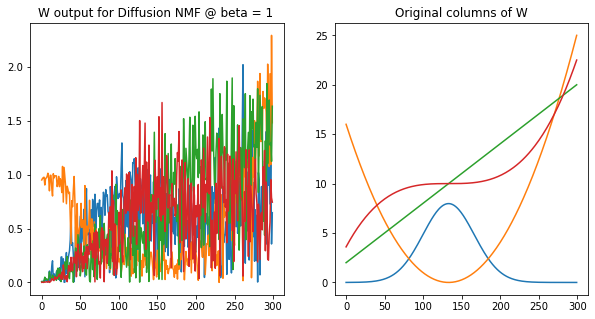

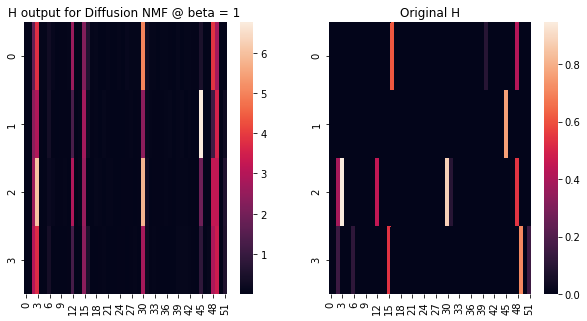

Diffusion NMF @ beta = 1 error on W:  320.9365734254849
Diffusion NMF @ beta = 1 error on H:  17.16360417913135
Diffusion NMF @ beta = 1 error on D:  4.71100347339888

Diffusion NMF X correlation with W:  0.5980922638763052
Diffusion NMF V correlation with H:  0.6073124744314312

K Condition Number : 80.43139193082577


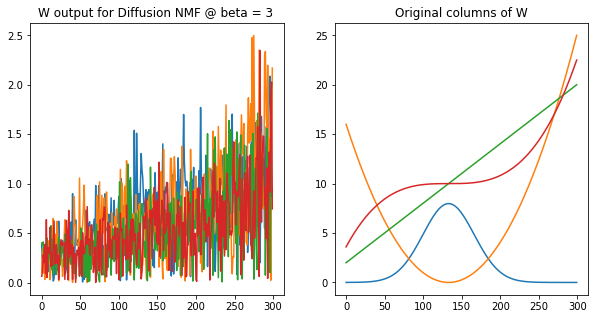

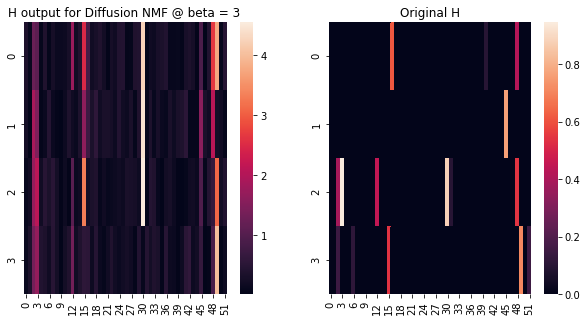

Diffusion NMF @ beta = 3 error on W:  323.716534927594
Diffusion NMF @ beta = 3 error on H:  12.37235551586168
Diffusion NMF @ beta = 3 error on D:  5.317005733847859

Diffusion NMF X correlation with W:  0.3836460755322132
Diffusion NMF V correlation with H:  0.4378305207624825

K Condition Number : 265.7713064360867


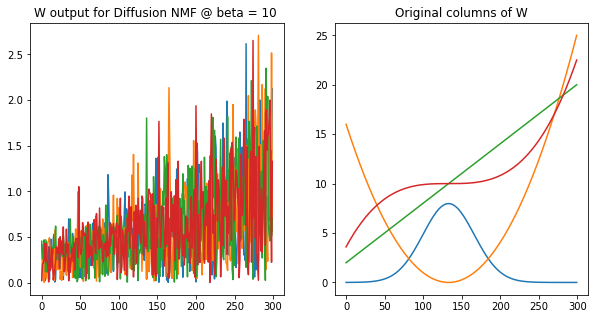

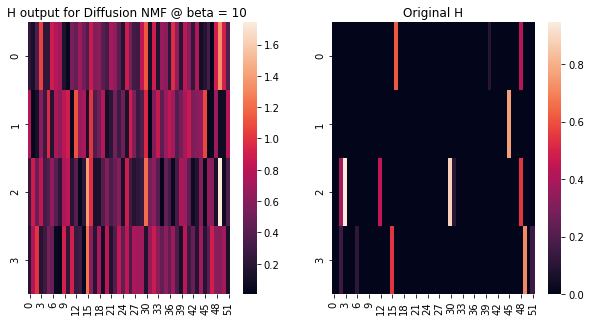

Diffusion NMF @ beta = 10 error on W:  323.14260835706824
Diffusion NMF @ beta = 10 error on H:  8.158390379394298
Diffusion NMF @ beta = 10 error on D:  4.915034629711779

Diffusion NMF X correlation with W:  0.3243174079713733
Diffusion NMF V correlation with H:  0.23977190580405325



In [28]:
diffn_plot(W,H,L, [1,3,10], algorithm = 'MultUpdate', sparseness = None)

### State adjacency Laplacian

In [29]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [30]:
np.trace(state_L)

218

K Condition Number : 10.95709432694549


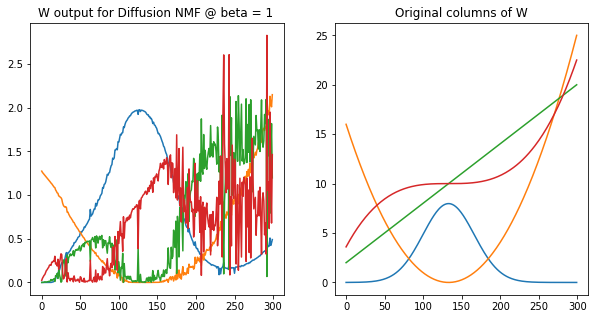

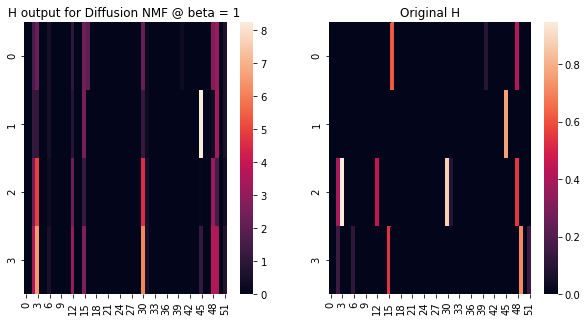

Diffusion NMF @ beta = 1 error on W:  316.51667413000314
Diffusion NMF @ beta = 1 error on H:  17.09963468985691
Diffusion NMF @ beta = 1 error on D:  24.48622484272098

Diffusion NMF X correlation with W:  0.8025396128565356
Diffusion NMF V correlation with H:  0.6680647028431238

K Condition Number : 30.871282980836465


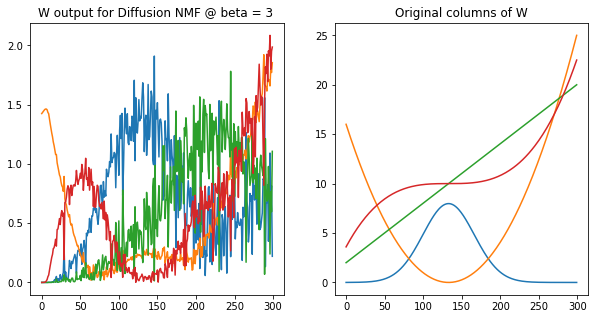

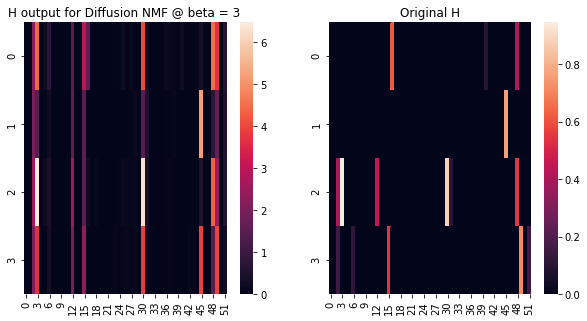

Diffusion NMF @ beta = 3 error on W:  319.4761711972549
Diffusion NMF @ beta = 3 error on H:  16.796259237920154
Diffusion NMF @ beta = 3 error on D:  3.899677083733973

Diffusion NMF X correlation with W:  0.8242124182717627
Diffusion NMF V correlation with H:  0.6548645797019222

K Condition Number : 100.57094326945528


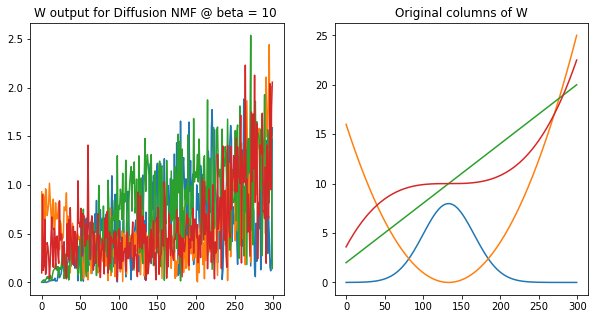

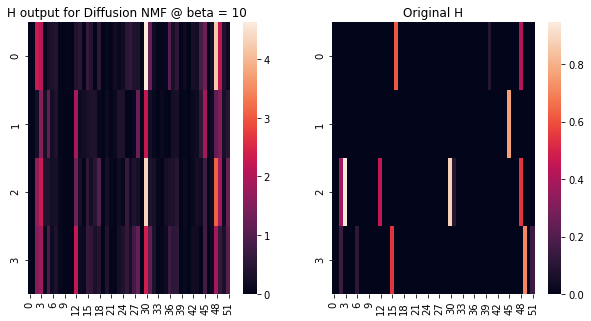

Diffusion NMF @ beta = 10 error on W:  320.72239132923863
Diffusion NMF @ beta = 10 error on H:  11.838330250507939
Diffusion NMF @ beta = 10 error on D:  9.0339291850104

Diffusion NMF X correlation with W:  0.5301450297975909
Diffusion NMF V correlation with H:  0.4067891656383717



In [31]:
diffn_plot(W,H,state_L, [1,3,10], algorithm = 'MultUpdate',sparseness = None)

### Hoyer Projection

K Condition Number : 10.95709432694549


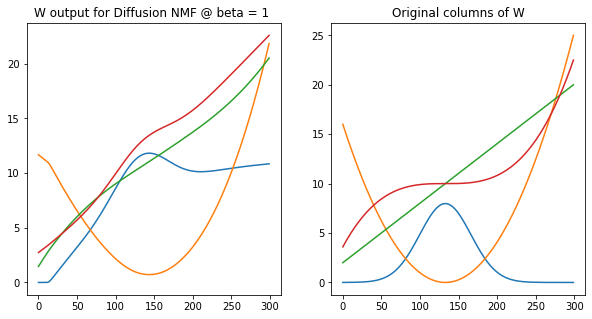

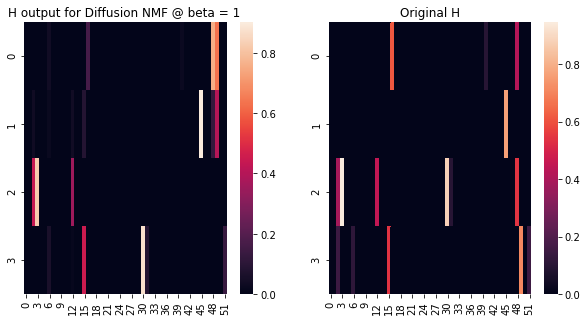

Diffusion NMF @ beta = 1 error on W:  138.12264883584993
Diffusion NMF @ beta = 1 error on H:  1.829990221974275
Diffusion NMF @ beta = 1 error on D:  16.808692588602355

Diffusion NMF X correlation with W:  0.8287229990210131
Diffusion NMF V correlation with H:  0.6017798168293196

K Condition Number : 30.871282980836465


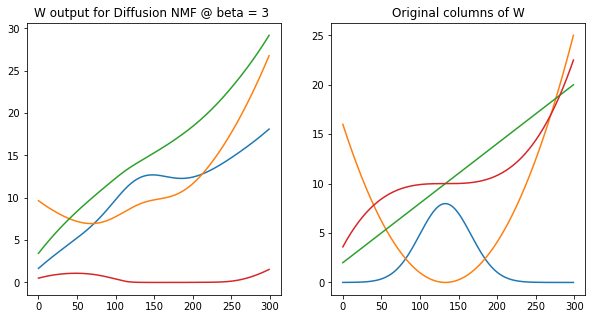

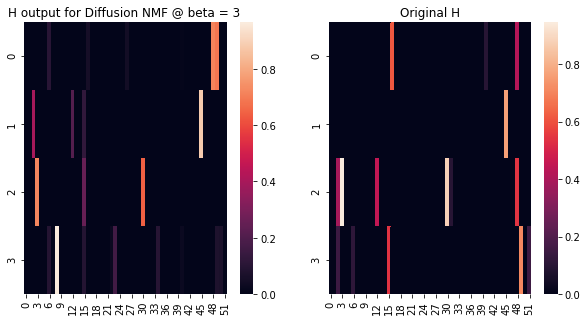

Diffusion NMF @ beta = 3 error on W:  292.8918641797611
Diffusion NMF @ beta = 3 error on H:  1.893628365345943
Diffusion NMF @ beta = 3 error on D:  7.968937183614586

Diffusion NMF X correlation with W:  0.4875001858145814
Diffusion NMF V correlation with H:  0.546497809046256

K Condition Number : 100.57094326945528


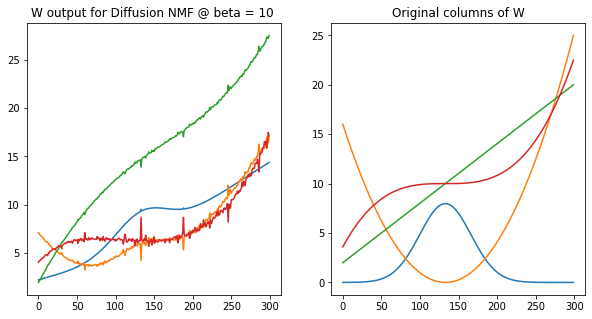

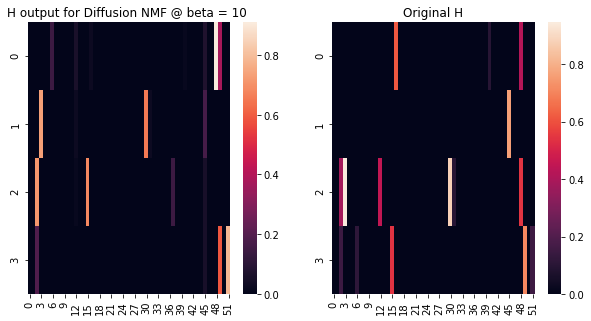

Diffusion NMF @ beta = 10 error on W:  179.8657633217483
Diffusion NMF @ beta = 10 error on H:  2.359706356591287
Diffusion NMF @ beta = 10 error on D:  18.910565209063165

Diffusion NMF X correlation with W:  0.7007825141960412
Diffusion NMF V correlation with H:  0.3437668818089258



In [32]:
diffn_plot(W,H,state_L, [1,3,10], algorithm = 'HoyerP',sparseness = h_sparse)

### Modified Multiplicative update

K Condition Number : 10.95709432694549


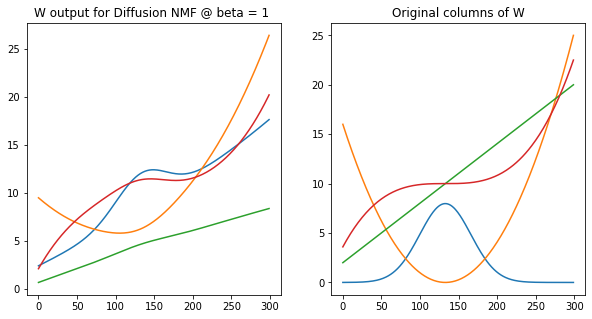

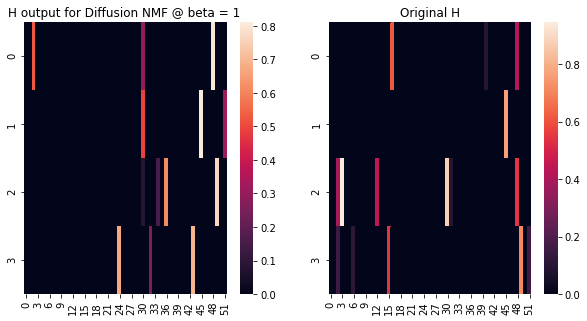

Diffusion NMF @ beta = 1 error on W:  223.81126503100796
Diffusion NMF @ beta = 1 error on H:  2.507539570206237
Diffusion NMF @ beta = 1 error on D:  60.001521170586855

Diffusion NMF X correlation with W:  0.7267684226167805
Diffusion NMF V correlation with H:  0.2867316131111598

K Condition Number : 30.871282980836465


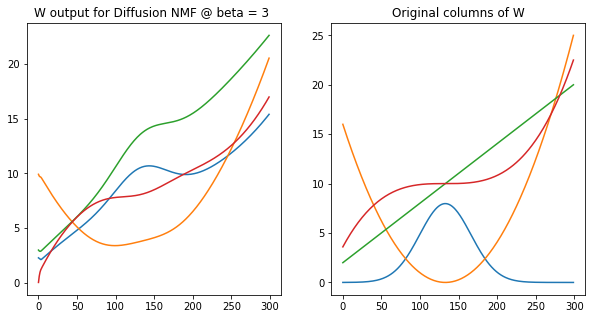

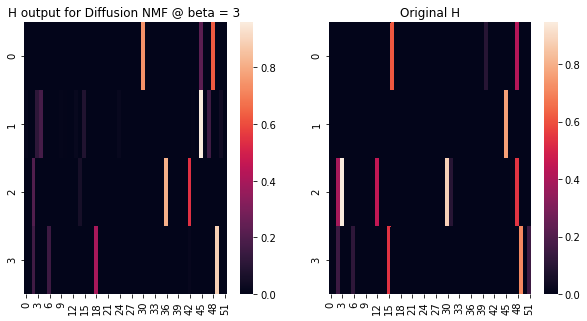

Diffusion NMF @ beta = 3 error on W:  154.81081951263627
Diffusion NMF @ beta = 3 error on H:  2.19910127950302
Diffusion NMF @ beta = 3 error on D:  25.129900891043192

Diffusion NMF X correlation with W:  0.7614727982331373
Diffusion NMF V correlation with H:  0.4951092992345921

K Condition Number : 100.57094326945528


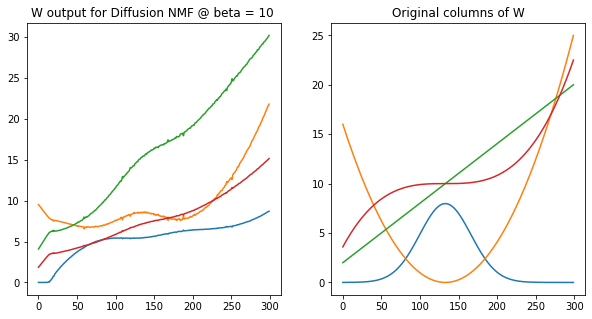

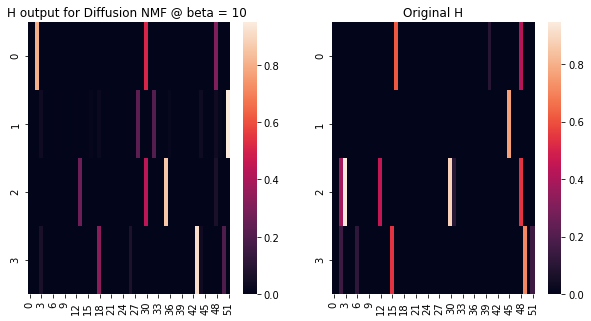

Diffusion NMF @ beta = 10 error on W:  161.0947897839936
Diffusion NMF @ beta = 10 error on H:  2.689245257978382
Diffusion NMF @ beta = 10 error on D:  24.726953572692196

Diffusion NMF X correlation with W:  0.7146959811255778
Diffusion NMF V correlation with H:  0.06674103985105262



In [33]:
# do the derived multiplicative updates but project after each V update
diffn_plot(W,H,state_L, [1,3,10], algorithm = 'MultProj', sparseness = h_sparse)

### Original Hoyer algorithm (No projection)

K Condition Number : 27.477130643608547


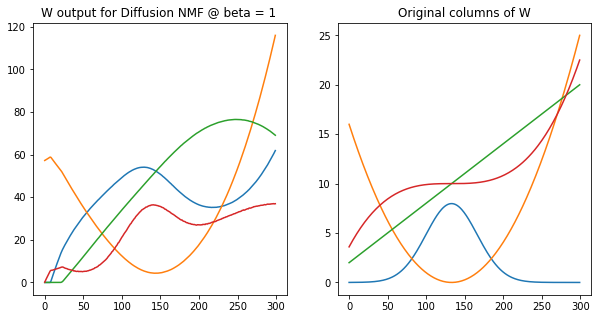

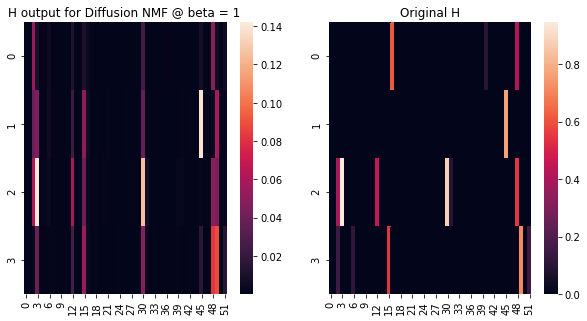

Diffusion NMF @ beta = 1 error on W:  1191.3831817903201
Diffusion NMF @ beta = 1 error on H:  1.8310001661781985
Diffusion NMF @ beta = 1 error on D:  9.80470472959506

Diffusion NMF X correlation with W:  0.804927131102712
Diffusion NMF V correlation with H:  0.6844589124107533

K Condition Number : 80.43139193082577


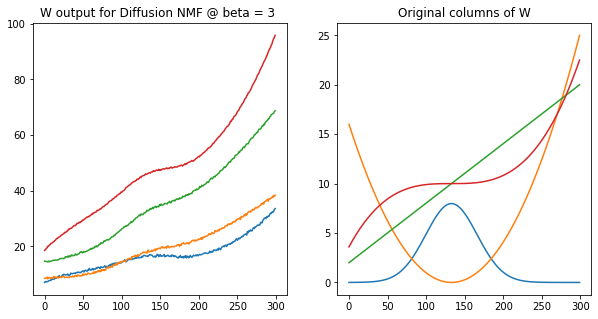

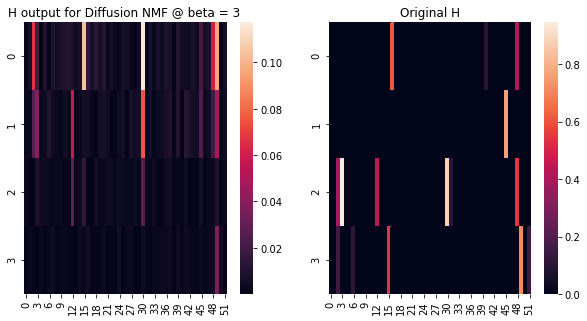

Diffusion NMF @ beta = 3 error on W:  921.1508108647168
Diffusion NMF @ beta = 3 error on H:  2.0365244463633227
Diffusion NMF @ beta = 3 error on D:  63.25376890166209

Diffusion NMF X correlation with W:  0.5853578986211672
Diffusion NMF V correlation with H:  0.3906228247231429

K Condition Number : 265.7713064360867


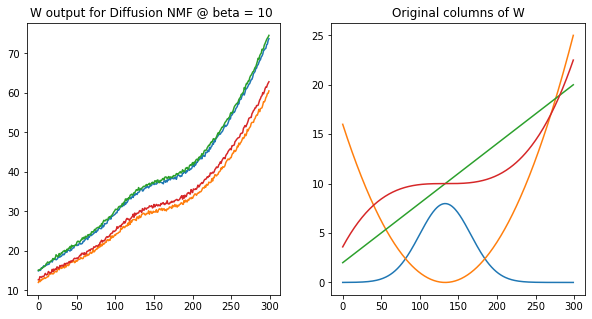

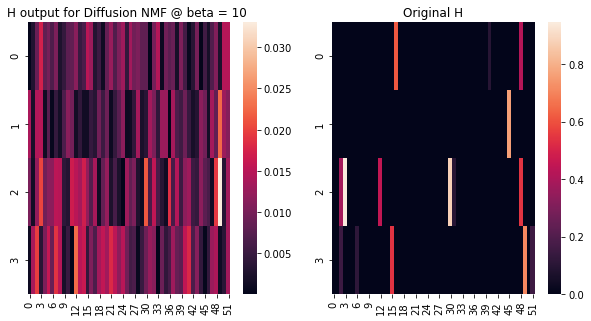

Diffusion NMF @ beta = 10 error on W:  1030.7088787069206
Diffusion NMF @ beta = 10 error on H:  2.044524704466754
Diffusion NMF @ beta = 10 error on D:  3.0297891630207716

Diffusion NMF X correlation with W:  0.5709260977090773
Diffusion NMF V correlation with H:  0.12056423551352992



In [34]:
diffn_plot(W,H,state_L, [1,3,10], iters = 1000, algorithm = 'HoyerS', lambda_v = 10)

### Two phase algorithm

K Condition Number : 10.95709432694549


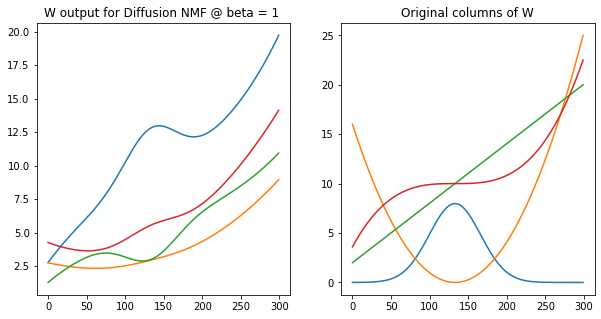

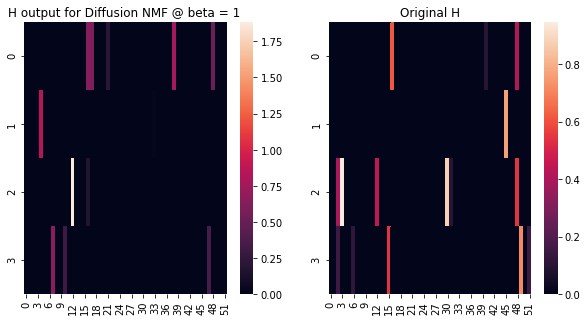

Diffusion NMF @ beta = 1 error on W:  248.04611706562537
Diffusion NMF @ beta = 1 error on H:  2.8281349952849295
Diffusion NMF @ beta = 1 error on D:  90.44705980186168

Diffusion NMF X correlation with W:  0.6816551780367043
Diffusion NMF V correlation with H:  0.19713208413230762

K Condition Number : 30.871282980836465


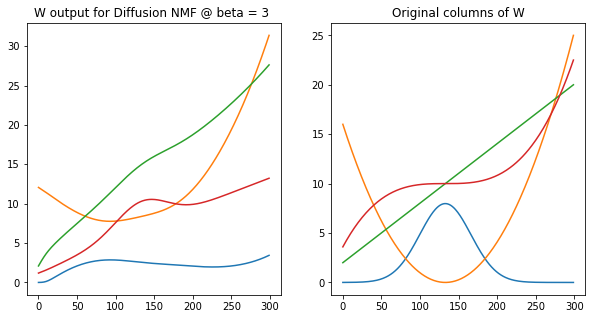

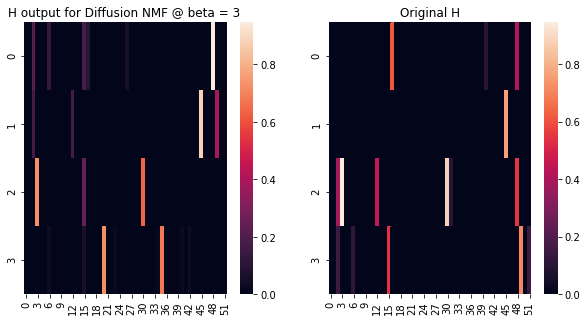

Diffusion NMF @ beta = 3 error on W:  157.7537955462595
Diffusion NMF @ beta = 3 error on H:  1.8685507310003513
Diffusion NMF @ beta = 3 error on D:  43.64063318477434

Diffusion NMF X correlation with W:  0.7735145489710982
Diffusion NMF V correlation with H:  0.5676370398982338

K Condition Number : 100.57094326945528


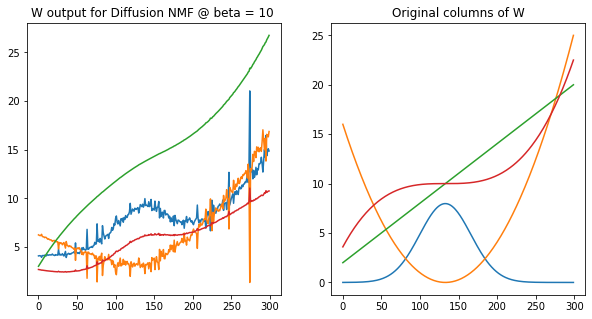

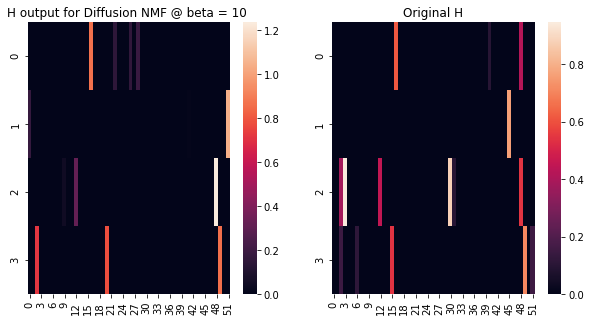

Diffusion NMF @ beta = 10 error on W:  178.09668294791896
Diffusion NMF @ beta = 10 error on H:  2.378491823530225
Diffusion NMF @ beta = 10 error on D:  38.664232949082916

Diffusion NMF X correlation with W:  0.7082425961195675
Diffusion NMF V correlation with H:  0.41872842489094464



In [35]:
diffn_plot(W,H,state_L, [1,3,10], algorithm = 'TwoPhase', sparseness = h_sparse)

### Least squares algorithm

K Condition Number : 10.95709432694549


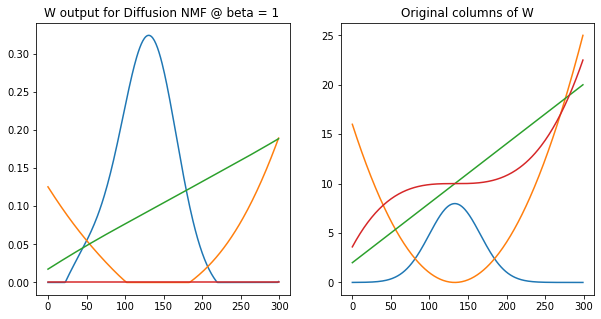

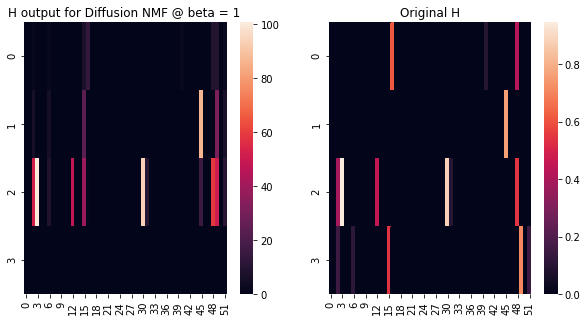

Diffusion NMF @ beta = 1 error on W:  339.76734634590144
Diffusion NMF @ beta = 1 error on H:  202.44655998410207
Diffusion NMF @ beta = 1 error on D:  6.601245053092897

Diffusion NMF X correlation with W:  0.7289503423177113
Diffusion NMF V correlation with H:  0.6243410396972942

K Condition Number : 30.871282980836465


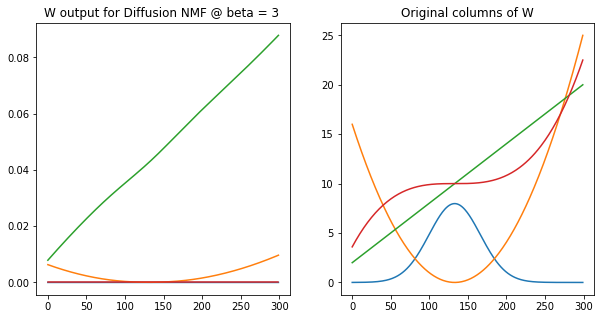

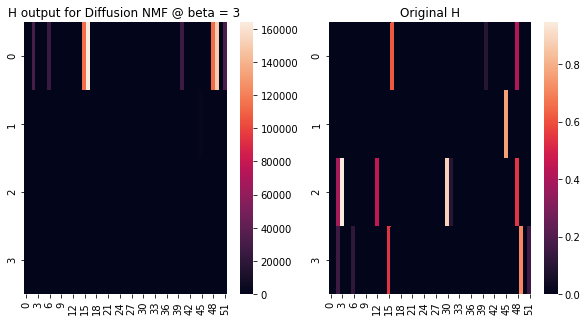

Diffusion NMF @ beta = 3 error on W:  341.4361755926018
Diffusion NMF @ beta = 3 error on H:  280190.0383700523
Diffusion NMF @ beta = 3 error on D:  4.159583584073362

Diffusion NMF X correlation with W:  0.7287346715880817
Diffusion NMF V correlation with H:  0.6058116050870203

K Condition Number : 100.57094326945528


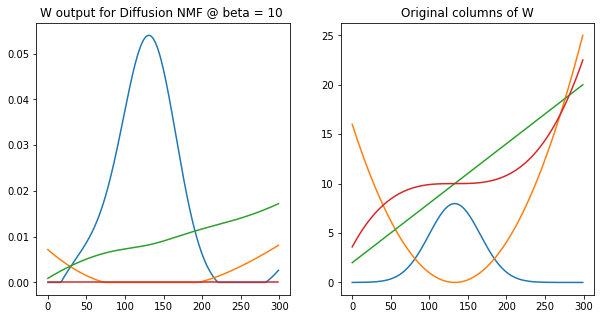

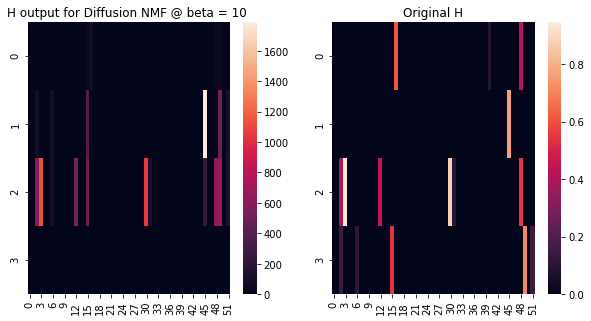

Diffusion NMF @ beta = 10 error on W:  341.82390020581545
Diffusion NMF @ beta = 10 error on H:  2800.9148393596483
Diffusion NMF @ beta = 10 error on D:  3.633728239099927

Diffusion NMF X correlation with W:  0.6839152049453378
Diffusion NMF V correlation with H:  0.6377291282439672



In [36]:
diffn_plot(W,H,state_L, [1,3,10], algorithm = 'LeastSquares', beta = 10, eta = 1)

## Comparison Tests

In [36]:
def comparer(d,x,v,k):
    res1 = []
    res2 = []

    # Normal errors
    res1.append(np.linalg.norm(d - np.dot(x, np.dot(v, k))))
    res1.append(np.linalg.norm(W - x))
    res1.append(np.linalg.norm(H - v))

    # correlation
    d_test = np.dot(x, np.dot(v, k))
    res2.append(correlation(d, d_test, axis = 0))
    res2.append(correlation(W.to_numpy(), x, axis = 0))
    res2.append(correlation(H.to_numpy(), v, axis = 1))
    return res1, res2

In [37]:
def test_algs(d, l, beta, sparseness,lambda_v, iters = 1000, noise = None):
    # for comparing the different algorithms
    K_b = np.linalg.inv(I + beta * l)

    # algorithm 1 -- multiplicative update (no sparse constraint)
    if noise is not None:
        alg1 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg1 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg1.solver('MultUpdate')
    alg1_errs, alg1_corrs = comparer(d, reorder(W, alg1.X), reorder(H, alg1.V), K_b)
    

    # algorithm 2 -- modified Hoyer algorithm
    if noise is not None:
        alg2 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg2 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg2.solver('HoyerP', sparseness = sparseness)
    alg2_errs, alg2_corrs = comparer(d, reorder(W, alg2.X), reorder(H, alg2.V), K_b)
    

    # algorithm 3 -- projected Multiplicative update
    if noise is not None:
        alg3 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg3 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg3.solver('MultProj', sparseness = sparseness)
    alg3_errs, alg3_corrs = comparer(d, reorder(W, alg3.X), reorder(H, alg3.V), K_b)
    
    
    # algorithm 4 -- Hoyer sparse coding
    if noise is not None:
        alg4 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg4 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg4.solver('HoyerS', lambda_v = lambda_v)
    alg4_errs, alg4_corrs = comparer(d, reorder(W, alg4.X), reorder(H, alg4.V), K_b)
    

    # algorithm 5 -- two phase algorithm
    if noise is not None:
        alg5 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg5 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg5.solver('TwoPhase', sparseness = sparseness)
    alg5_errs, alg5_corrs = comparer(d, reorder(W, alg5.X), reorder(H, alg5.V), K_b)

    return np.array([alg1_errs, alg2_errs, alg3_errs, alg4_errs, alg5_errs]), np.array([alg1_corrs, alg2_corrs, alg3_corrs, alg4_corrs, alg5_corrs])

In [38]:
def test_betas(d, l, beta_vals, sparseness, lambda_v, iters = 1000, noise = None):
    errors = [[[] for i in range (3)] for j in range(5)]
    corrs = [[[] for i in range (3)] for j in range(5)]
    
    for b in beta_vals:
        errz, corrz = test_algs(d,l,b, sparseness, lambda_v, iters = iters, noise = noise)
        for e in range(len(errz)):
            for a in range(len(errz[0])):
                errors[e][a].append(errz[e][a])
                corrs[e][a].append(corrz[e][a])
    return np.array(errors), np.array(corrs)

In [39]:
betab = 3
K_real = np.linalg.inv(I + betab * state_L)
alg_D = np.dot(W, np.dot(H, K_real))

In [40]:
def comp_plotter(x_vals, errors, xlabel, ylabel, vline):
    fig, ax = plt.subplots(1, 3, figsize = (20,10))
    for er in range(len(errors[0])):
        ax[er].plot(x_vals, errors[0][er], label = "Mult Update")
        ax[er].plot(x_vals, errors[1][er], label = "Hoyer Projection")
        ax[er].plot(x_vals, errors[2][er], label = "Mult Update w/ projection")
        ax[er].plot(x_vals, errors[3][er], label = "Hoyer Sparse Coding")
        ax[er].plot(x_vals, errors[4][er], label = "Two Phase")

        xer = np.array([])
        for r in range(len(errors)):
            xer = np.append(xer, errors[r][[er]])
        maxer = max(1,xer.max())

        ax[er].vlines(vline, -1, maxer, linestyle = 'dashed', color = 'k')

    ax[0].set_title(ylabel + " on actual D")
    ax[1].set_title(ylabel + " on actual W")
    ax[2].set_title(ylabel + " on actual H")
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel)
    ax[2].set_xlabel(xlabel)
    ax[2].set_ylabel(ylabel)
    plt.legend()
    plt.show()

In [41]:
b_vals = range(1,10)
errors, corrs = test_betas(alg_D, state_L, b_vals, h_sparse, lambda_v = 10)

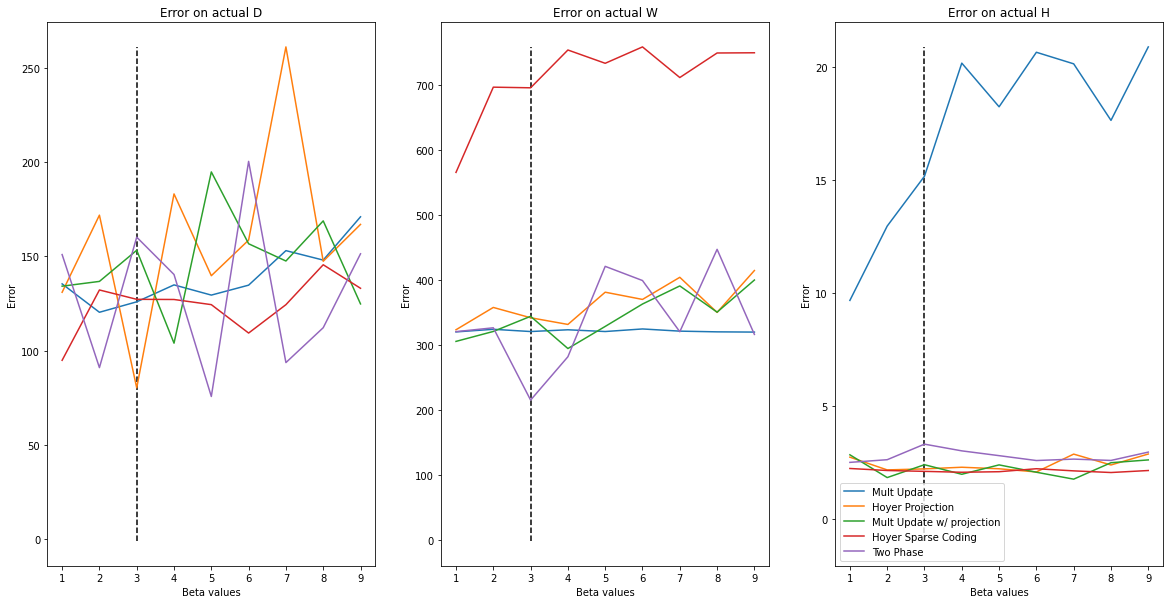

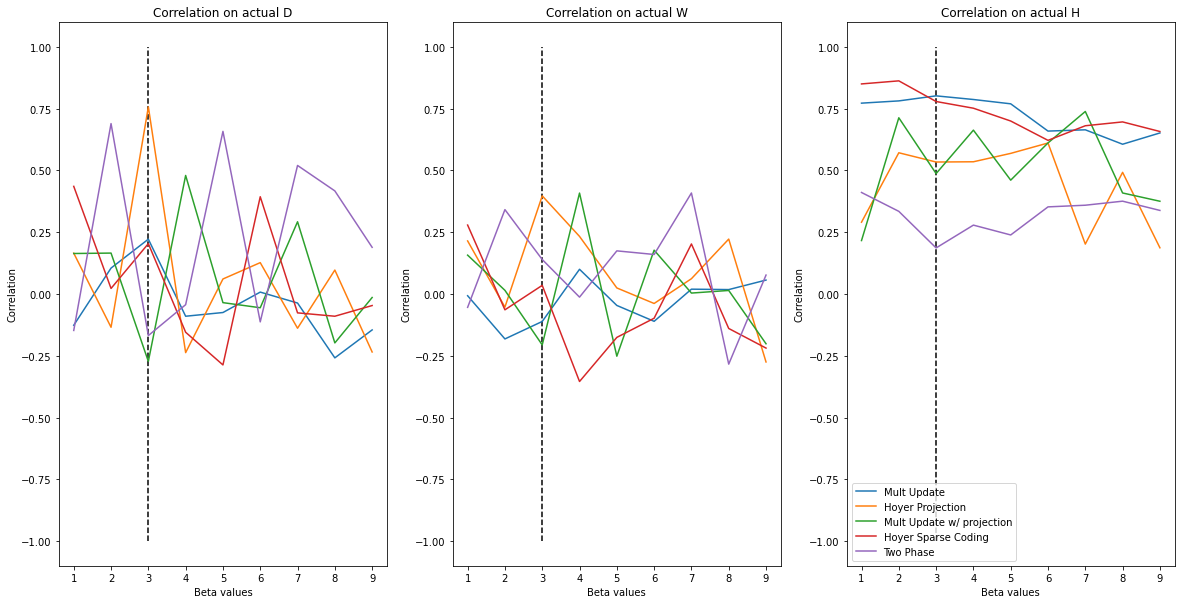

In [42]:
comp_plotter(b_vals, errors, 'Beta values', 'Error', betab)
comp_plotter(b_vals, corrs, 'Beta values', 'Correlation', betab)

### Average over multiple runs

In [43]:
# Average over multiple tests: 
tests = 10
b_vals = range(1,10)
errors = None
for t in range(tests):
    if errors is None:
        errors, corrs = test_betas(alg_D, state_L, b_vals, h_sparse, lambda_v = h_sparse * 10)
    else:
        e, c = test_betas(alg_D, state_L, b_vals, h_sparse, lambda_v = h_sparse * 10)
        errors += e
        corrs += c

errors /= tests
corrs /= tests

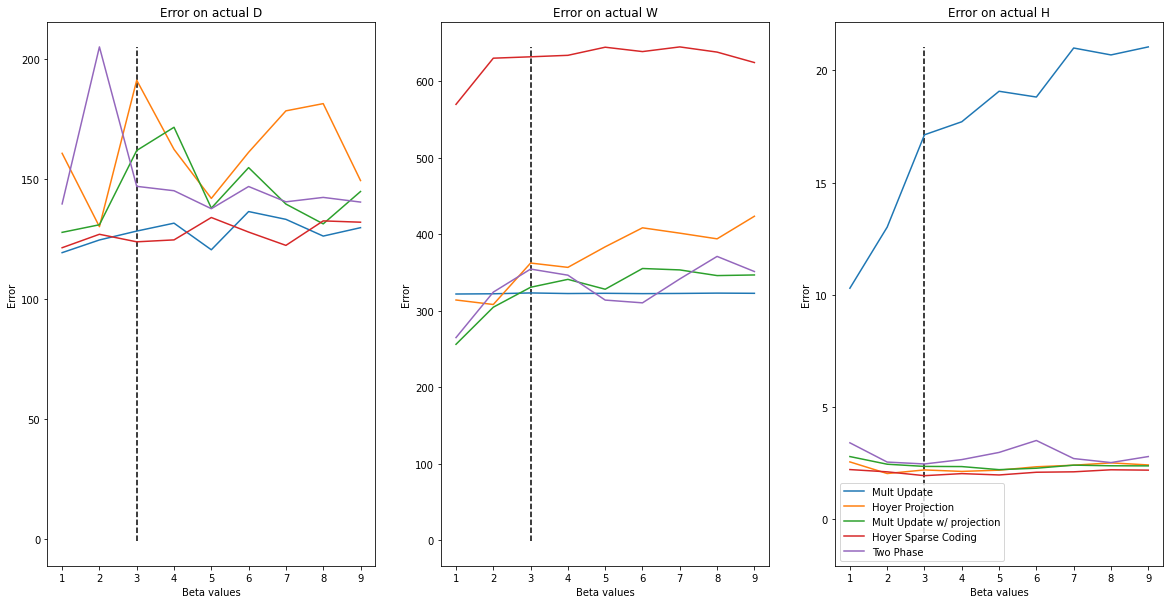

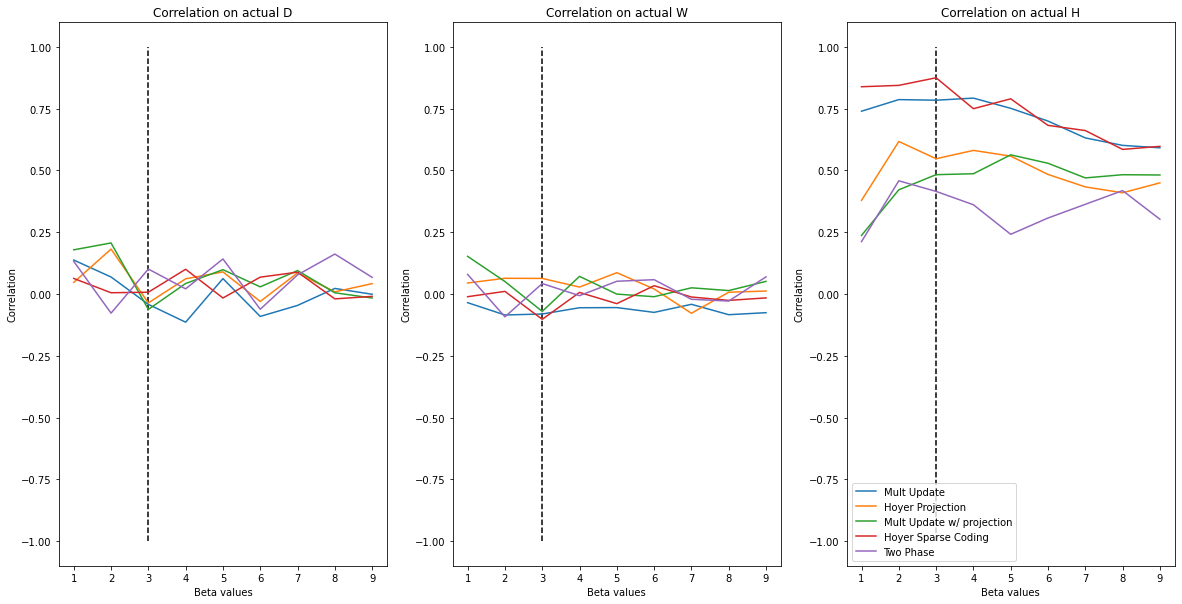

In [44]:
comp_plotter(b_vals, errors, 'Beta values', 'Error', betab)
comp_plotter(b_vals, corrs, 'Beta values', 'Correlation', betab)

### Multiple runs With noise added to D

In [45]:
def noiser(matr, changes):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    noises = int(changes * matr.shape[0] * matr.shape[1])
    
    taken = {take:[] for take in range(matr.shape[0])}
    for n in range(noises):
        x = random.randint(0, matr.shape[0] - 1)
        while True:
            y = random.randint(0, matr.shape[1] - 1)
            if y not in taken[x]:
                break
        
        noisy = np.random.normal()
        if matr[x, y] + noisy < 0:
            matr[x, y] = 0
        else:
            matr[x, y] += noisy
            
    return matr
        
    

In [46]:
tests = 10
b_vals = range(1,10)
errors2 = None
corrs2 = None
for t in range(tests):
    if errors2 is None:
        errors2, corrs2 = test_betas(alg_D, state_L, b_vals, h_sparse, lambda_v = h_sparse * 10, noise = noiser(alg_D, 0.2))
    else:
        e,c = test_betas(alg_D, state_L, b_vals, h_sparse, lambda_v = h_sparse *10, noise = noiser(alg_D, 0.2))
        errors2 += e
        corrs2 += c

errors2 /= tests    
corrs2 /= tests

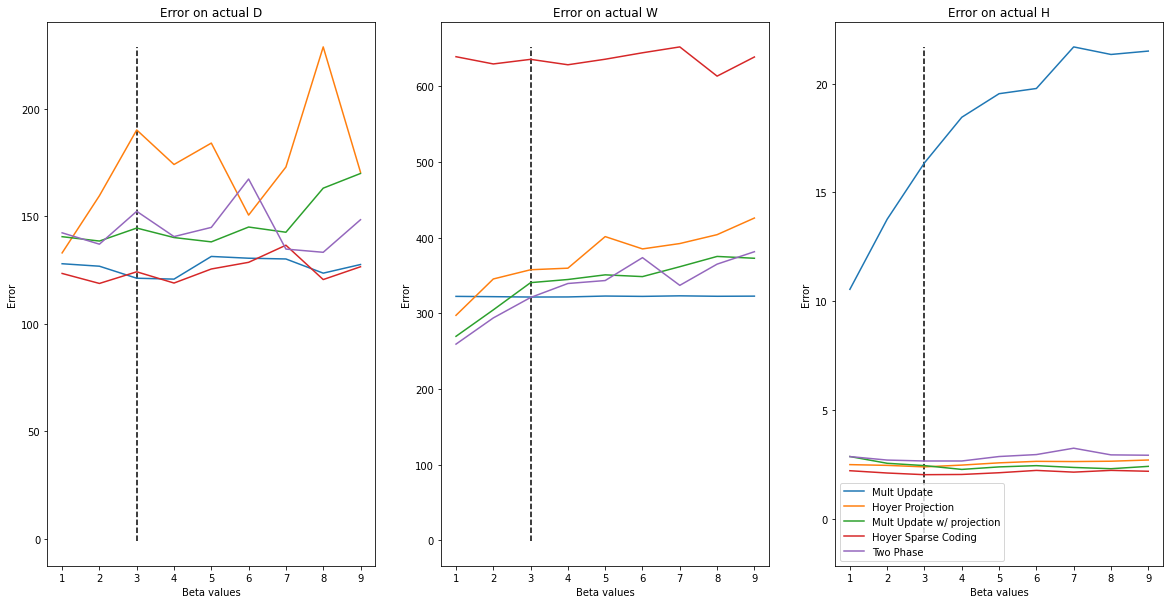

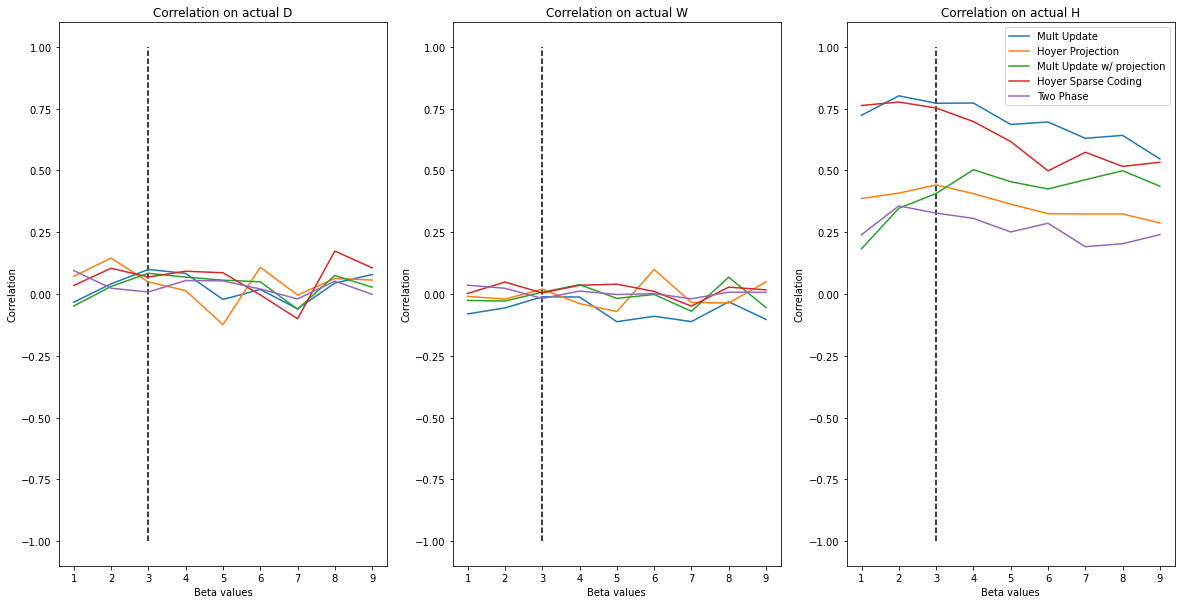

In [47]:
comp_plotter(b_vals, errors2, 'Beta values', 'Error', betab)
comp_plotter(b_vals, corrs2, 'Beta values', 'Correlation', betab)

## Testing sparseness values

In [48]:
def test_sparseness(d, l, beta, sparse_vals, lambda_v, noise = None, iters = 1000):
    errors = [[[] for i in range (3)] for j in range(5)]
    corrs = [[[] for i in range (3)] for j in range(5)]
    
    for s in sparse_vals:
        errz, corrz = test_algs(d,l,beta, s, s * lambda_v, noise = noise, iters = iters)
        for e in range(len(errz)):
            for a in range(len(errz[0])):
                errors[e][a].append(errz[e][a])
                corrs[e][a].append(corrz[e][a])
                
    return np.array(errors), np.array(corrs)

In [49]:
sparz = np.linspace(0.5,0.99, 10)
s_errors, s_corrs = test_sparseness(alg_D, state_L, betab, sparz, lambda_v = 10)

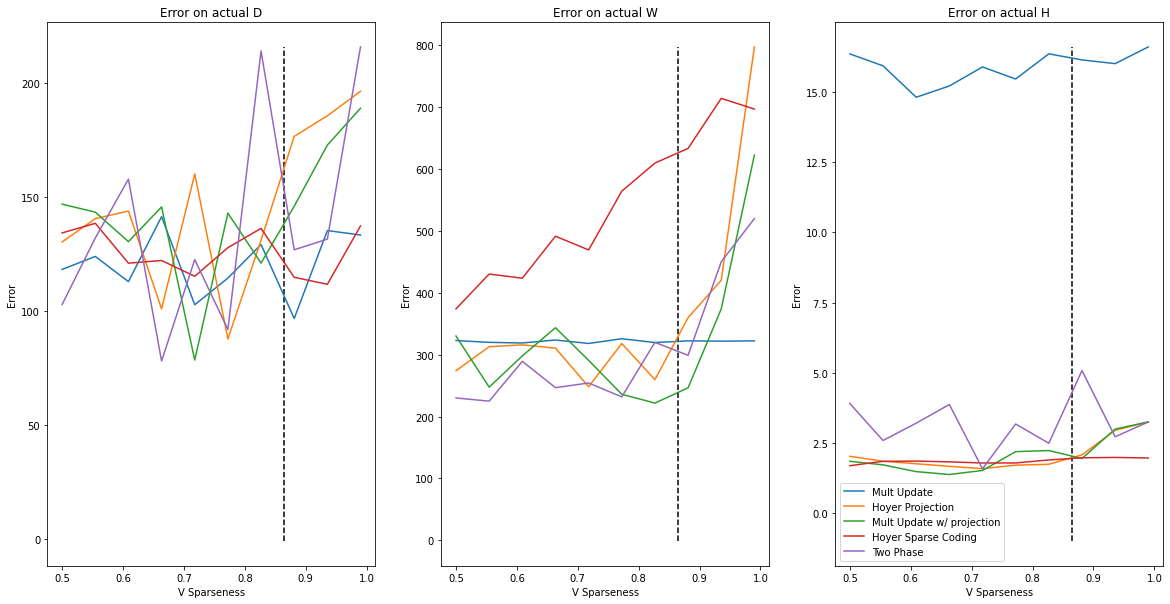

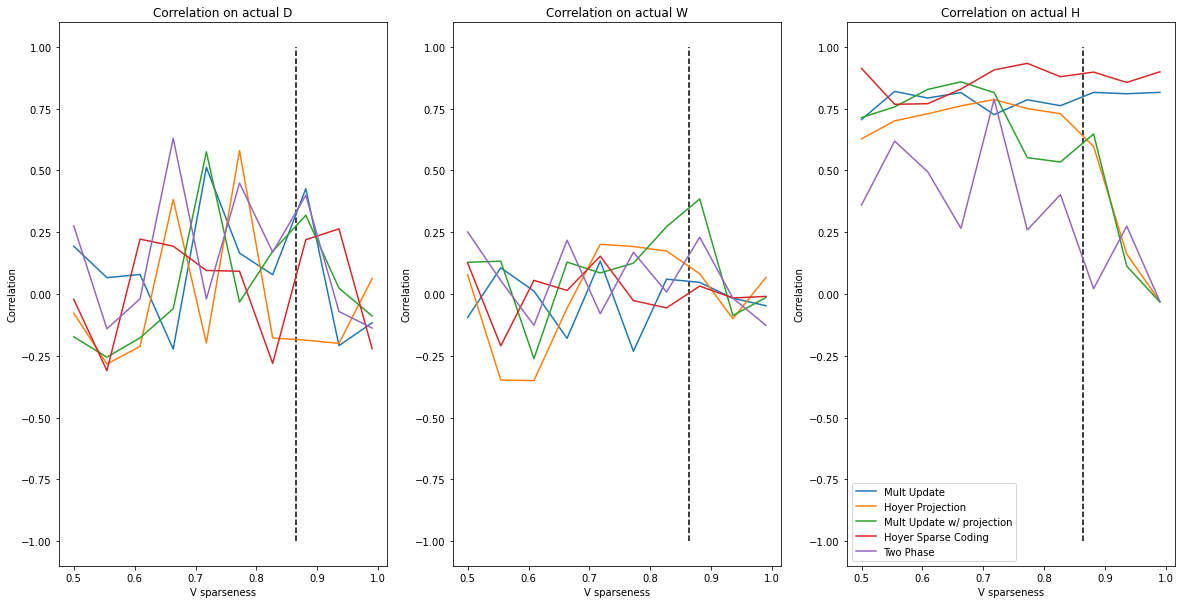

In [50]:
comp_plotter(sparz, s_errors, 'V Sparseness', 'Error', h_sparse)
comp_plotter(sparz, s_corrs, 'V sparseness', 'Correlation', h_sparse)

### Average over multiple runs

In [51]:
# Average over multiple tests: 
tests = 10
sparz = np.linspace(0.5,0.99, 10)
sm_errors = None
sm_corrs = None
for t in range(tests):
    if sm_errors is None:
        sm_errors, sm_corrs = test_sparseness(alg_D, state_L, betab, sparz, lambda_v = 10)
    else:
        e, c = test_sparseness(alg_D, state_L, betab, sparz, lambda_v = 10)
        sm_errors += e
        sm_corrs += c

sm_errors /= tests
sm_corrs /= tests

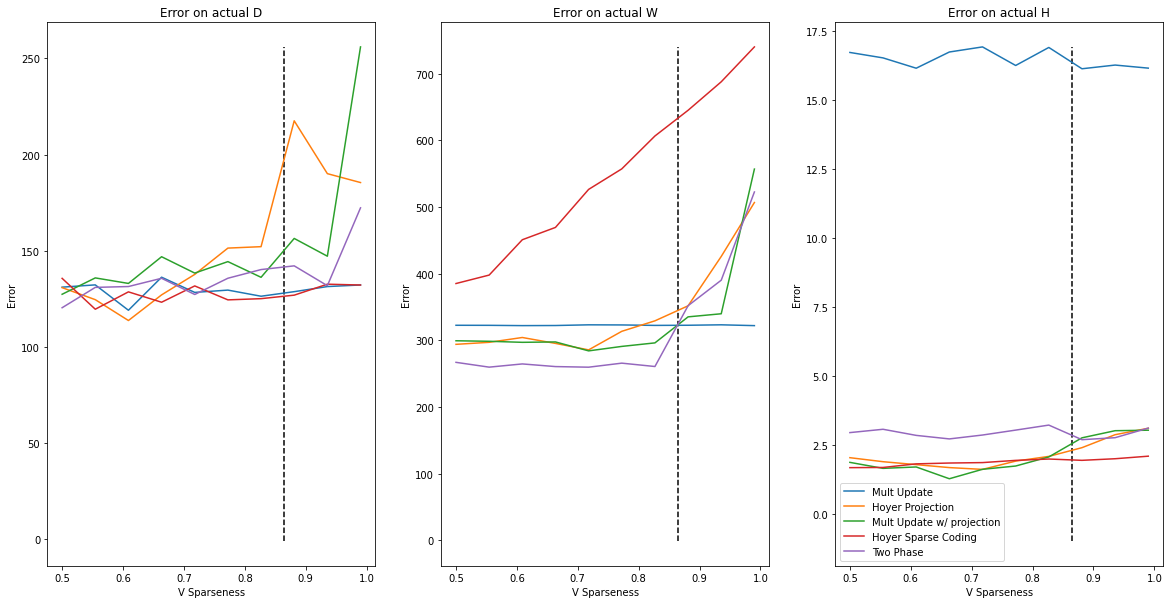

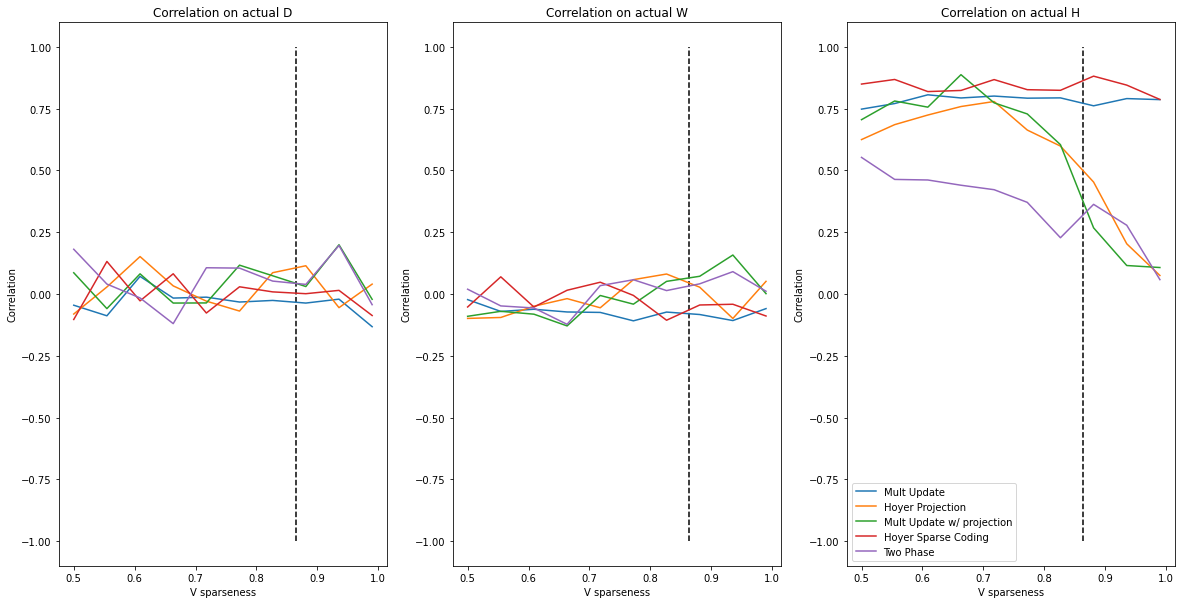

In [52]:
comp_plotter(sparz, sm_errors, 'V Sparseness', 'Error', h_sparse)
comp_plotter(sparz, sm_corrs, 'V sparseness', 'Correlation', h_sparse)

### Multiple runs with Noise added to D

In [53]:
# Average over multiple tests: 
tests = 10
sparz = np.linspace(0.5,0.99, 10)
sm_errors2 = None
sm_corrs2 = None
for t in range(tests):
    if sm_errors2 is None:
        sm_errors2, sm_corrs2 = test_sparseness(alg_D, state_L, betab, sparz, lambda_v = 10, noise = noiser(alg_D, 0.2))
    else:
        e, c = test_sparseness(alg_D, state_L, betab, sparz, lambda_v = 10, noise = noiser(alg_D, 0.2))
        sm_errors2 += e
        sm_corrs2 += c

sm_errors2 /= tests
sm_corrs2 /= tests

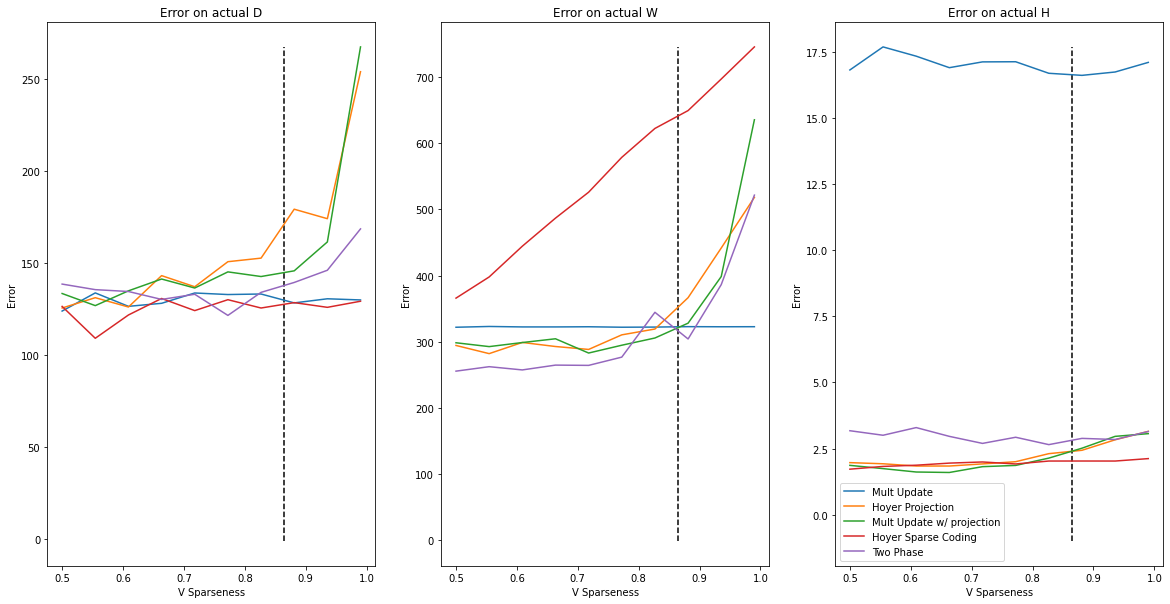

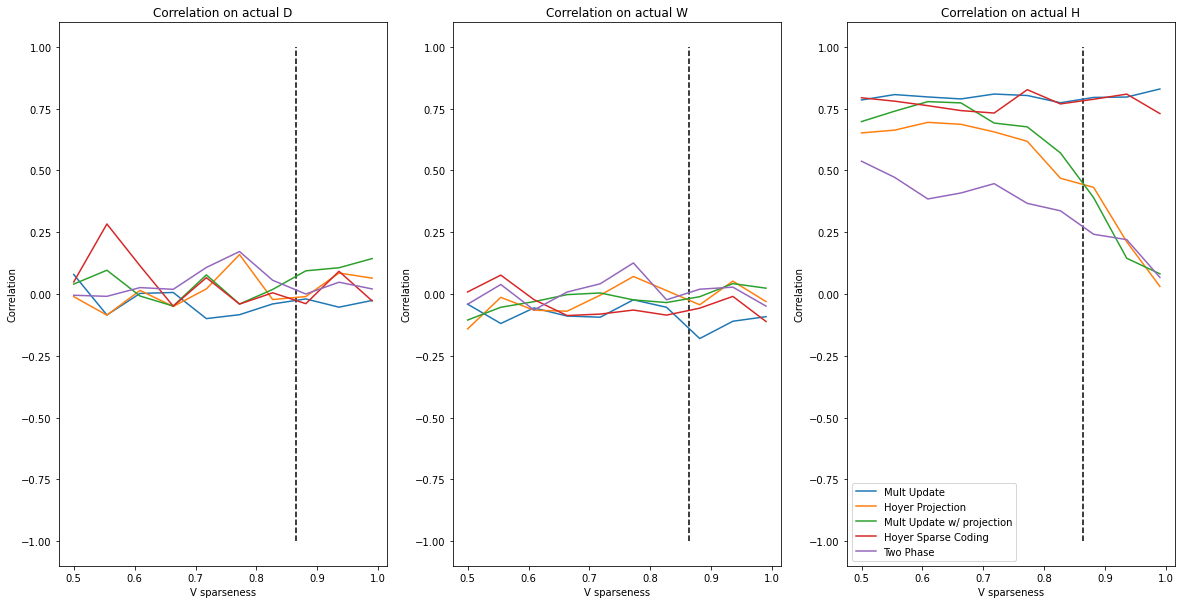

In [54]:
comp_plotter(sparz, sm_errors2, 'V Sparseness', 'Error', h_sparse)
comp_plotter(sparz, sm_corrs2, 'V sparseness', 'Correlation', h_sparse)